In [1]:

#######NO TRANSFORMATIONS
#with depthwise and not using pooling layers: 0.412 test 0.430 train
#with depthwise and using pooling layers: 0.443 test and 0.562 train



#50.1% with all transformations       and this gives no ovrefitting
#50.4 with disabling rotation #     some overfitting
#49.8% with disabling crop      #slightmore more overfitting than disabling rotation

**Main imports**

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display as disp


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [5]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]



def get_mean_std(loader):
    # Initialize sums and counters
    channel_sum = torch.tensor([0.0, 0.0, 0.0])
    channel_squared_sum = torch.tensor([0.0, 0.0, 0.0])
    num_batches = 0
    
    for images, _ in loader:
        
        channel_sum += images.mean([0, 2, 3]) * images.size(0)
        channel_squared_sum += images.pow(2).mean([0, 2, 3]) * images.size(0)
        num_batches += images.size(0)
    
   
    mean = channel_sum / num_batches
    std = (channel_squared_sum / num_batches - mean.pow(2)).sqrt()
    
    return mean, std


temp_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True, num_workers=2, drop_last=True)

mean, std = get_mean_std(temp_loader)
print(f'Mean: {mean}')
print(f'Std: {std}')


transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15)
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=transformation),
    batch_size=128, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean,std)
    ])),
    batch_size=128, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Mean: tensor([0.5071, 0.4866, 0.4409])
Std: tensor([0.2673, 0.2564, 0.2761])
Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

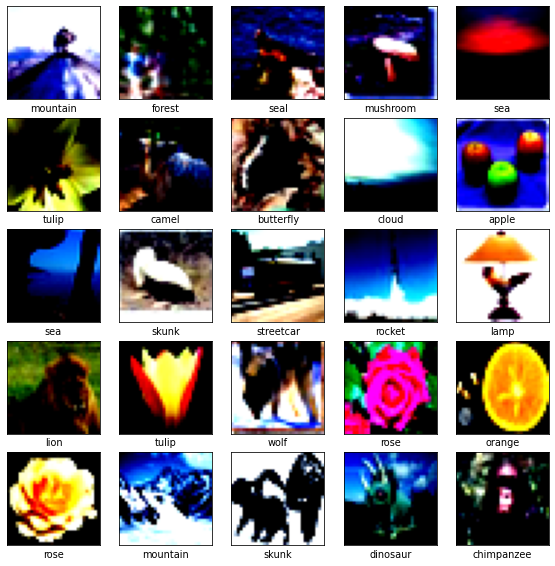

In [4]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

**Define a simple model**

In [8]:
# 4x2x1 pattern or 3x1x1 

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                                   padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class Classifier(nn.Module):
    def __init__(self, num_classes=100):
        super(Classifier, self).__init__()
        self.initial_conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.initial_bn = nn.BatchNorm2d(16)
        self.initial_relu = nn.ReLU(inplace=True)
        
        self.block1 = DepthwiseSeparableConv(16, 32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block2 = DepthwiseSeparableConv(32, 64)
        self.block3 = DepthwiseSeparableConv(64, 128)
        self.block4 = DepthwiseSeparableConv(128, 256)

        self.adp_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.initial_relu(self.initial_bn(self.initial_conv(x)))
        x = self.pool(self.block1(x))
        x = self.pool(self.block2(x))
        x = self.pool(self.block3(x))
        x = self.pool(self.block4(x))
        x = self.adp_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


params = {
    'n_channels': 3,
    'n_hidden': 30,  
    'n_classes':  
}

N = Classifier().to(device)


print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")


optimiser = torch.optim.AdamW(N.parameters(), lr=0.0015, weight_decay=1e-4)
plot_data = []
steps = 0


> Number of parameters 84194


**Main training and testing loop**

steps: 10000.00, train loss: 1.742, train acc: 0.525±0.045, test acc: 0.502±0.042


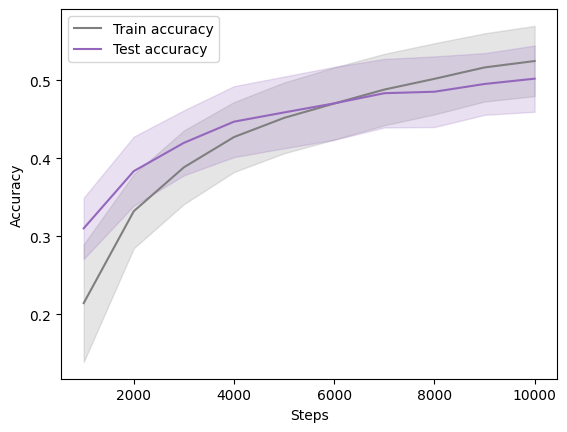

In [7]:
while (steps < 10000):

    
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()
        steps += 1

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N(x)
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    
    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(),train_acc_arr.mean(),train_acc_arr.std(),test_acc_arr.mean(),test_acc_arr.std()))

  
    plot_data.append([steps, np.array(train_acc_arr).mean(), np.array(train_acc_arr).std(), np.array(test_acc_arr).mean(), np.array(test_acc_arr).std()])
    reward_list = []
    plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    disp.clear_output(wait=True)

**Inference on dataset**

This is useful for analysis but is entirely optional

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(100), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())

'classifier_network.png'